### Bayesian logistic regression example with Laplace prior

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  
sys.path.append(project_root)

import torch
import numpy as np
import torch.optim as optim
import yaml
from easydict import EasyDict 
import matplotlib.pyplot as plt
import pickle
from logistic_regression.algorithms import pip_ula, sig, mypipla, mypgd, prox_pgd, proximal_map_laplace_iteration_total, proximal_map_laplace_iterative, proximal_map_laplace_approx, proximal_map_laplace_approx_total, pipgla
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

#### Obtain synthetic dataset for Laplace prior case

The algorithm is tested on a toy example consisting of a Bayesian logistic regression task with Laplace prior for the covariates.

In [2]:
# Data and design matrix
from scipy.stats import laplace, bernoulli
np.random.seed(3)
design_matrix = np.random.uniform(low = -1.0, high = 1.0, size = (900, 50))
x_unknown = laplace.rvs(loc = -4, size = (50, 1))
parameter_bernoulli = sig(np.matmul(design_matrix, x_unknown))
data_experiment = bernoulli.rvs(np.array(parameter_bernoulli[:, 0]), size = 900)
labels = np.expand_dims(data_experiment, axis=1)
np.mean(x_unknown)

-4.043582831009141

##### Moreau-Yosida PGD algorithm iteratively

100%|██████████| 2000/2000 [00:18<00:00, 110.35it/s]


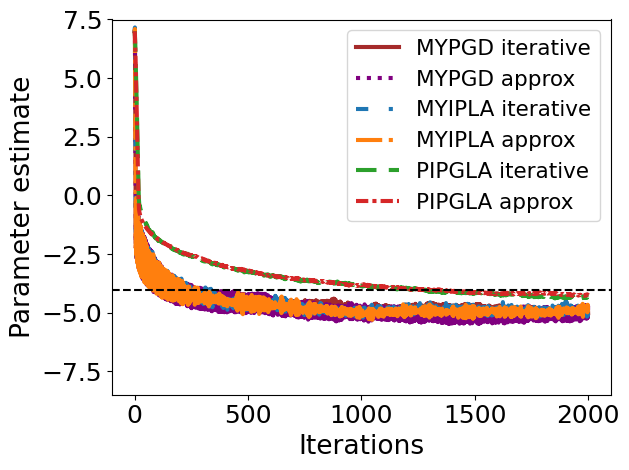

In [11]:
n_particles = 50
n_iterations = 2000

fig = plt.figure()


theta0 = 7
X0 = np.random.normal(loc = theta0, size=(50, n_particles))

## MYPGD iterative
thetas_approx, _ = mypgd(proximal_map = proximal_map_laplace_iterative, th = np.array([[theta0]]), X = X0, N = n_particles, design_matrix = design_matrix, data = labels, K = n_iterations, gamma = 0.005, h = 0.05)
plt.plot(thetas_approx, label = 'MYPGD iterative', linewidth=2.95, linestyle = "solid", color = "brown")

## MYPGD approx
thetas_approx, _ = mypgd(proximal_map = proximal_map_laplace_approx, th = np.array([[theta0]]), X = X0, N = n_particles, design_matrix = design_matrix, data = labels, K = n_iterations, gamma = 0.25, h = 0.05)
plt.plot(thetas_approx, label = 'MYPGD approx', linewidth=2.95, linestyle = "dotted", color = "purple")

## MYIPLA iterative
thetas_approx, _ = mypipla(proximal_map = proximal_map_laplace_iterative, th = np.array([[theta0]]), X = X0, N = n_particles, design_matrix = design_matrix, data = labels, K = n_iterations, gamma = 0.005, h = 0.05)
plt.plot(thetas_approx, label = 'MYIPLA iterative', linewidth=2.95, linestyle = (0, (3, 5, 1, 5)))

## MYIPLA approx
thetas_approx, _ = mypipla(proximal_map = proximal_map_laplace_approx, th = np.array([[theta0]]), X = X0, N = n_particles, design_matrix = design_matrix, data = labels, K = n_iterations, gamma = 0.35, h = 0.05)
plt.plot(thetas_approx, label = 'MYIPLA approx', linewidth=2.95, linestyle = "dashdot")

## PIPGLA iterative
thetas_approx, _ = pipgla(proximal_map = proximal_map_laplace_iterative, th = np.array([[theta0]]), X = X0, N = n_particles, design_matrix = design_matrix, data = labels, K = n_iterations, gamma = 0.01, h = 0.01)
plt.plot(thetas_approx, label = 'PIPGLA iterative', linewidth=2.95, linestyle = (5, (10, 3)))

## PIPGLA approx
thetas_approx, _ = pipgla(proximal_map = proximal_map_laplace_approx, th = np.array([[theta0]]), X = X0, N = n_particles, design_matrix = design_matrix, data = labels, K = n_iterations, gamma = 0.01, h = 0.01)
plt.plot(thetas_approx, label = 'PIPGLA approx', linewidth=2.95, linestyle = (0, (3, 1, 1, 1)))

plt.axhline(y=np.mean(x_unknown), color='black', linestyle='dashed')

plt.tick_params(labelsize=18)

# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('Parameter estimate', fontsize=19)

plt.ylim(-8.5, 7.5)
# Show legend
#ax.legend()
plt.legend(fontsize=15.5, loc='upper right')

# Show the plot
plt.show()

In [3]:
n_particles = 50
n_iterations = 2000


theta0 = 7

thetas_iterative_mypgd_values = []
thetas_approx_mypgd_values = []
thetas_iterative_mypipla_values = []
thetas_approx_mypipla_values = []
thetas_iterative_pipgla_values = []
thetas_approx_pipgla_values = []

for i in range(100):
    X0 = np.random.normal(loc=theta0, size=(50, n_particles))

    ## MYPGD iterative
    thetas_approx, _ = mypgd(proximal_map=proximal_map_laplace_iterative, th=np.array([[theta0]]), X=X0, N=n_particles, design_matrix=design_matrix, data=labels, K=n_iterations, gamma=0.005, h=0.05)
    thetas_iterative_mypgd_values.append(thetas_approx)

    ## MYPGD approx
    thetas_approx, _ = mypgd(proximal_map=proximal_map_laplace_approx, th=np.array([[theta0]]), X=X0, N=n_particles, design_matrix=design_matrix, data=labels, K=n_iterations, gamma=0.25, h=0.05)
    thetas_approx_mypgd_values.append(thetas_approx)

    ## MYIPLA iterative
    thetas_approx, _ = mypipla(proximal_map=proximal_map_laplace_iterative, th=np.array([[theta0]]), X=X0, N=n_particles, design_matrix=design_matrix, data=labels, K=n_iterations, gamma=0.005, h=0.05)
    thetas_iterative_mypipla_values.append(thetas_approx)

    ## MYIPLA approx
    thetas_approx, _ = mypipla(proximal_map=proximal_map_laplace_approx, th=np.array([[theta0]]), X=X0, N=n_particles, design_matrix=design_matrix, data=labels, K=n_iterations, gamma=0.35, h=0.05)
    thetas_approx_mypipla_values.append(thetas_approx)

    ## PIPGLA iterative
    thetas_approx, _ = pipgla(proximal_map=proximal_map_laplace_iterative, th=np.array([[theta0]]), X=X0, N=n_particles, design_matrix=design_matrix, data=labels, K=n_iterations, gamma=0.01, h=0.01)
    thetas_iterative_pipgla_values.append(thetas_approx)

    ## PIPGLA approx
    thetas_approx, _ = pipgla(proximal_map=proximal_map_laplace_approx, th=np.array([[theta0]]), X=X0, N=n_particles, design_matrix=design_matrix, data=labels, K=n_iterations, gamma=0.01, h=0.01)
    thetas_approx_pipgla_values.append(thetas_approx)

100%|██████████| 2000/2000 [00:12<00:00, 156.78it/s]


In [4]:
# Convert lists of lists to NumPy arrays
matrix_iterative_mypgd = np.array(thetas_iterative_mypgd_values)
matrix_approx_mypgd = np.array(thetas_approx_mypgd_values)
matrix_iterative_mypipla = np.array(thetas_iterative_mypipla_values)
matrix_approx_mypipla = np.array(thetas_approx_mypipla_values)
matrix_iterative_pipgla = np.array(thetas_iterative_pipgla_values)
matrix_approx_pipgla = np.array(thetas_approx_pipgla_values)

# Compute means
means_mypgd_iterative = np.mean(matrix_iterative_mypgd, axis=0)
means_mypgd_approx = np.mean(matrix_approx_mypgd, axis=0)
means_mypipla_iterative = np.mean(matrix_iterative_mypipla, axis=0)
means_mypipla_approx = np.mean(matrix_approx_mypipla, axis=0)
means_pipgla_iterative = np.mean(matrix_iterative_pipgla, axis=0)
means_pipgla_approx = np.mean(matrix_approx_pipgla, axis=0)

# Compute standard deviations
std_devs_mypgd_iterative = np.std(matrix_iterative_mypgd, axis=0)
std_devs_mypgd_approx = np.std(matrix_approx_mypgd, axis=0)
std_devs_mypipla_iterative = np.std(matrix_iterative_mypipla, axis=0)
std_devs_mypipla_approx = np.std(matrix_approx_mypipla, axis=0)
std_devs_pipgla_iterative = np.std(matrix_iterative_pipgla, axis=0)
std_devs_pipgla_approx = np.std(matrix_approx_pipgla, axis=0)

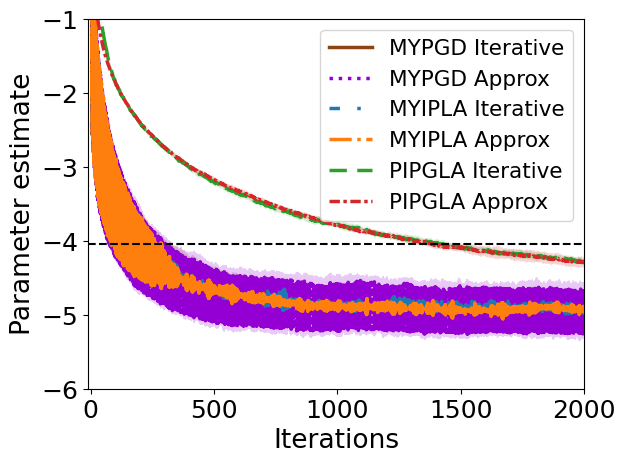

In [29]:
# Plot
fig = plt.figure()

# X-axis values (assuming 250 iterations)
x_values = np.linspace(0, 2000, 2001)

## MYPGD Iterative
plt.plot(means_mypgd_iterative, label='MYPGD Iterative', linewidth=2.5, linestyle="solid", color = "saddlebrown")
plt.fill_between(x_values, 
                 np.array(means_mypgd_iterative) - np.array(std_devs_mypgd_iterative), 
                 np.array(means_mypgd_iterative) + np.array(std_devs_mypgd_iterative), 
                 alpha=0.2, color="saddlebrown")

## MYPGD Approximate
plt.plot(means_mypgd_approx, label='MYPGD Approx', linewidth=2.5, linestyle="dotted", color = "darkviolet")
plt.fill_between(x_values, 
                 np.array(means_mypgd_approx) - np.array(std_devs_mypgd_approx), 
                 np.array(means_mypgd_approx) + np.array(std_devs_mypgd_approx), 
                 alpha=0.2, color="darkviolet")

## MYIPLA Iterative
plt.plot(means_mypipla_iterative, label='MYIPLA Iterative', linewidth=2.5, linestyle= (0, (3, 5, 1, 5)))
plt.fill_between(x_values, 
                 np.array(means_mypipla_iterative) - np.array(std_devs_mypipla_iterative), 
                 np.array(means_mypipla_iterative) + np.array(std_devs_mypipla_iterative), 
                 alpha=0.2)

## MYIPLA Approximate
plt.plot(means_mypipla_approx, label='MYIPLA Approx', linewidth=2.5, linestyle="dashdot")
plt.fill_between(x_values, 
                 np.array(means_mypipla_approx) - np.array(std_devs_mypipla_approx), 
                 np.array(means_mypipla_approx) + np.array(std_devs_mypipla_approx), 
                 alpha=0.2)

## PIPGLA Iterative
plt.plot(means_pipgla_iterative, label='PIPGLA Iterative', linewidth=2.5, linestyle=(5, (10, 3)))
plt.fill_between(x_values, 
                 np.array(means_pipgla_iterative) - np.array(std_devs_pipgla_iterative), 
                 np.array(means_pipgla_iterative) + np.array(std_devs_pipgla_iterative), 
                 alpha=0.2)

## PIPGLA Approximate
plt.plot(means_pipgla_approx, label='PIPGLA Approx', linewidth=2.5, linestyle= (0, (3, 1, 1, 1)))
plt.fill_between(x_values, 
                 np.array(means_pipgla_approx) - np.array(std_devs_pipgla_approx), 
                 np.array(means_pipgla_approx) + np.array(std_devs_pipgla_approx), 
                 alpha=0.2)

plt.axhline(y=np.mean(x_unknown), color='black', linestyle='dashed')
plt.tick_params(labelsize=18)

# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('Parameter estimate', fontsize=19)

plt.legend(fontsize=15.5, loc='upper right')
plt.xlim(-10, 2000)
plt.ylim(-6, -1)

# Save the figure
path_fig_estimates = os.path.join(project_root, 'logistic_regression/100_runs_parameter_estimates_laplace_prior.pdf')

fig.savefig(path_fig_estimates, format='pdf', bbox_inches='tight')

In [18]:
# Define true value
theta_true = -4

# Compute element-wise NMSE
def compute_elementwise_nmse(matrix, true_value):
    return ((matrix - true_value) ** 2) / 16  # 16 = (-4)^2

# Compute NMSE for each method
nmse_mypgd_iterative = compute_elementwise_nmse(matrix_iterative_mypgd, theta_true)
nmse_mypgd_approx = compute_elementwise_nmse(matrix_approx_mypgd, theta_true)
nmse_mypipla_iterative = compute_elementwise_nmse(matrix_iterative_mypipla, theta_true)
nmse_mypipla_approx = compute_elementwise_nmse(matrix_approx_mypipla, theta_true)
nmse_pipgla_iterative = compute_elementwise_nmse(matrix_iterative_pipgla, theta_true)
nmse_pipgla_approx = compute_elementwise_nmse(matrix_approx_pipgla, theta_true)

# Compute means and standard deviations of NMSE
means_nmse_mypgd_iterative = np.mean(nmse_mypgd_iterative, axis=0)
means_nmse_mypgd_approx = np.mean(nmse_mypgd_approx, axis=0)
means_nmse_mypipla_iterative = np.mean(nmse_mypipla_iterative, axis=0)
means_nmse_mypipla_approx = np.mean(nmse_mypipla_approx, axis=0)
means_nmse_pipgla_iterative = np.mean(nmse_pipgla_iterative, axis=0)
means_nmse_pipgla_approx = np.mean(nmse_pipgla_approx, axis=0)

std_devs_nmse_mypgd_iterative = np.std(nmse_mypgd_iterative, axis=0)
std_devs_nmse_mypgd_approx = np.std(nmse_mypgd_approx, axis=0)
std_devs_nmse_mypipla_iterative = np.std(nmse_mypipla_iterative, axis=0)
std_devs_nmse_mypipla_approx = np.std(nmse_mypipla_approx, axis=0)
std_devs_nmse_pipgla_iterative = np.std(nmse_pipgla_iterative, axis=0)
std_devs_nmse_pipgla_approx = np.std(nmse_pipgla_approx, axis=0)


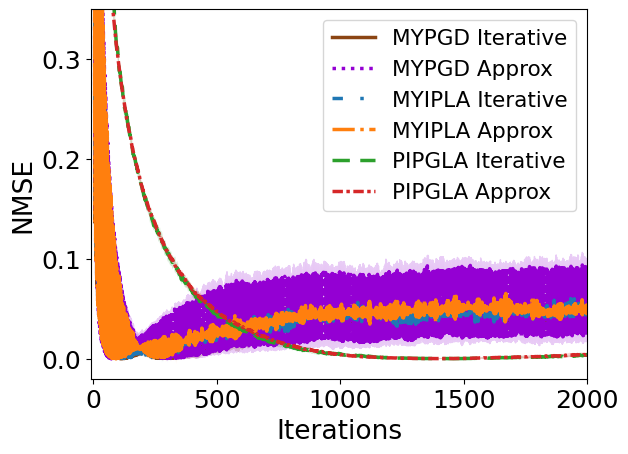

In [26]:
# Plot

fig = plt.figure()

# X-axis values (assuming 2001 iterations)
x_values = np.linspace(0, 2000, 2001)

## MYPGD Iterative
plt.plot(means_nmse_mypgd_iterative, label='MYPGD Iterative', linewidth=2.5, linestyle="solid", color="saddlebrown")
plt.fill_between(x_values, 
                 means_nmse_mypgd_iterative - std_devs_nmse_mypgd_iterative, 
                 means_nmse_mypgd_iterative + std_devs_nmse_mypgd_iterative, 
                 alpha=0.2, color="saddlebrown")

## MYPGD Approximate
plt.plot(means_nmse_mypgd_approx, label='MYPGD Approx', linewidth=2.5, linestyle="dotted", color="darkviolet")
plt.fill_between(x_values, 
                 means_nmse_mypgd_approx - std_devs_nmse_mypgd_approx, 
                 means_nmse_mypgd_approx + std_devs_nmse_mypgd_approx, 
                 alpha=0.2, color="darkviolet")

## MYIPLA Iterative
plt.plot(means_nmse_mypipla_iterative, label='MYIPLA Iterative', linewidth=2.5, linestyle=(0, (3, 5, 1, 5)))
plt.fill_between(x_values, 
                 means_nmse_mypipla_iterative - std_devs_nmse_mypipla_iterative, 
                 means_nmse_mypipla_iterative + std_devs_nmse_mypipla_iterative, 
                 alpha=0.2)

## MYIPLA Approximate
plt.plot(means_nmse_mypipla_approx, label='MYIPLA Approx', linewidth=2.5, linestyle="dashdot")
plt.fill_between(x_values, 
                 means_nmse_mypipla_approx - std_devs_nmse_mypipla_approx, 
                 means_nmse_mypipla_approx + std_devs_nmse_mypipla_approx, 
                 alpha=0.2)

## PIPGLA Iterative
plt.plot(means_nmse_pipgla_iterative, label='PIPGLA Iterative', linewidth=2.5, linestyle=(5, (10, 3)))
plt.fill_between(x_values, 
                 means_nmse_pipgla_iterative - std_devs_nmse_pipgla_iterative, 
                 means_nmse_pipgla_iterative + std_devs_nmse_pipgla_iterative, 
                 alpha=0.2)

## PIPGLA Approximate
plt.plot(means_nmse_pipgla_approx, label='PIPGLA Approx', linewidth=2.5, linestyle=(0, (3, 1, 1, 1)))
plt.fill_between(x_values, 
                 means_nmse_pipgla_approx - std_devs_nmse_pipgla_approx, 
                 means_nmse_pipgla_approx + std_devs_nmse_pipgla_approx, 
                 alpha=0.2)

# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('NMSE', fontsize=19)
plt.legend(fontsize=15.5, loc='upper right')
plt.xlim(-10, 2000)
plt.ylim(-0.02, 0.35)  # Adjust based on NMSE values
plt.tick_params(labelsize=18)

# Save the figure
path_fig_nmse = os.path.join(project_root, 'logistic_regression/100_runs_nmse_evolution_laplace_prior.pdf')

fig.savefig(path_fig_nmse, format='pdf', bbox_inches='tight')